In [1]:
%pylab inline
import numpy as np
import sklearn.linear_model as linear
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as selection
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.datasets as datasets
import pandas as pd
import torch as th
import torch.nn as nn
import torch.optim as optim

import scipy.stats as stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()
        
    def forward(self, X):
        return None 
    
    def loss(self, X, y):
        probs = self.forward(X)
        return self.loss_func(probs, y)
    
    def predict_proba(self, X, as_numpy=False):
        res = self.forward(X)
        if as_numpy:
            res = res.detach().numpy()
        return res
    
    def predict(self, X, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(X, as_numpy)
        return probs > threshold
    
    def fit(self, X, y, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        loss_curve = []
        for _ in range(epochs):
            optimizer.zero_grad()
            loss_val = self.loss(X, y) + self.regularize(lam)
            loss_curve.append(loss_val.data.item())
            loss_val.backward()
            optimizer.step()
        return loss_curve
    
    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [3]:
class NN1Model(MoonModel):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(9, 2, bias=True)
        self.act1 = nn.Sigmoid()
        self.l2 = nn.Linear(2, 1, bias=True)
        self.act2 = nn.Sigmoid()
        
    
    def forward(self, X):
        res = self.l1(X)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)
        return res

In [4]:
def plot_loss(loss_curve):
    plt.plot(list(range(len(loss_curve))), loss_curve)

In [5]:
df = pd.read_csv('breast-cancer-wisconsin.data', header=None)

for i in df:
    df[i]=df[i].replace('?', np.nan)
    df[i].fillna(df[i].mode()[0], inplace=True)
    df[i]=df[i].astype(int)
    

In [6]:
le = LabelEncoder()

target=df[10]
inputs=df.drop([0,10], axis=1)
print(inputs)
le.fit(target)
target=le.transform(target)

scaler = StandardScaler()
scaler.fit(inputs)
inputs = scaler.transform(inputs)

     1   2   3  4  5   6   7   8  9
0    5   1   1  1  2   1   3   1  1
1    5   4   4  5  7  10   3   2  1
2    3   1   1  1  2   2   3   1  1
3    6   8   8  1  3   4   3   7  1
4    4   1   1  3  2   1   3   1  1
..  ..  ..  .. .. ..  ..  ..  .. ..
694  3   1   1  1  3   2   1   1  1
695  2   1   1  1  2   1   1   1  1
696  5  10  10  3  7   3   8  10  2
697  4   8   6  4  3   4  10   6  1
698  4   8   8  5  4   5  10   4  1

[699 rows x 9 columns]


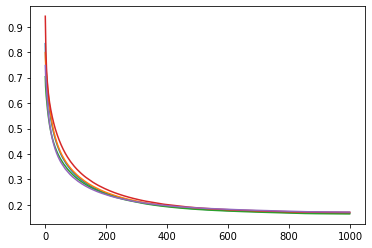

In [7]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(inputs)


#logistic regression
f1_lr=[]
prec_lr=[]
rec_lr=[]
acc_lr=[]

#neural network

f1_nn=[]
prec_nn=[]
rec_nn=[]
acc_nn=[]

for train_index, test_index in kf.split(inputs):
    X_train, X_test, y_train, y_test = inputs[train_index], inputs[test_index], target[train_index], target[test_index]
    
    #logistic regression
    logreg = LogisticRegression(solver='lbfgs')
    logreg.fit(X_train, y_train)
    pred = logreg.predict(X_test)
    f1_lr.append(metrics.f1_score(y_test, pred))
    prec_lr.append(metrics.precision_score(y_test, pred))
    rec_lr.append(metrics.recall_score(y_test, pred))
    acc_lr.append(metrics.accuracy_score(y_test, pred))
    
    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test,dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)
    
    #neural network
    model = NN1Model()
    curve = model.fit(X_train, y_train, lr=0.007, lam=0.01)
    plot_loss(curve)
    predictions = model.predict(X_test, as_numpy=True)
    f1_nn.append(metrics.f1_score(y_test, predictions))
    prec_nn.append(metrics.precision_score(y_test, pred))
    rec_nn.append(metrics.recall_score(y_test, pred))
    acc_nn.append(metrics.accuracy_score(y_test, pred))

In [8]:
print("Linear Regression")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print("Average F1 Score: ", np.mean(f1_lr)*100,"%")
print("Average Precision: ", np.mean(prec_lr)*100,"%")
print("Average Recall: ", np.mean(rec_lr)*100,"%")
print("Average Accuracy: ", np.mean(rec_lr)*100,"%")

Linear Regression
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Average F1 Score:  95.20201321334619 %
Average Precision:  95.22923877561361 %
Average Recall:  95.2920238802592 %
Average Accuracy:  95.2920238802592 %


In [9]:
print("Neural Network")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print("Average F1 Score: ", np.mean(f1_nn)*100,"%")
print("Average Precision: ", np.mean(prec_nn)*100,"%")
print("Average Recall: ", np.mean(rec_nn)*100,"%")
print("Average Accuracy: ", np.mean(rec_nn)*100,"%")

Neural Network
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Average F1 Score:  95.4407497120607 %
Average Precision:  95.22923877561361 %
Average Recall:  95.2920238802592 %
Average Accuracy:  95.2920238802592 %


In [10]:
print("T Test Result: ",stats.ttest_rel(f1_lr, f1_nn))

T Test Result:  Ttest_relResult(statistic=-0.5566677575557654, pvalue=0.6074278530855615)


In terms of precision, recall and accuracy, logistic regression and the neural network model performed almost equally.  In terms of F1, which considers both the precision and recall of the respective models, the Neural Network performed better.  However, the difference in performance of the two models is not significant.  With a p value above 0.1 while using a 0.05 significance level, we cannot reject that the models performed the same.  There is no statistically significant difference between the two models.  This is because with only one hidden layer, the neural network is not very complex and behaves much like the logistic regression classifier.  